# EEG Data interpretation -  Meditation and Individual Alpha Frequency (iAF)

This notebook processes EEG data of subjects that participated in the following experimental protocol:

Baseline blocks
	1.	Eyes Open (EO) – 2 minutes
	2.	Eyes Closed (EC) – 2 minutes

Task blocks
	3.	No music + finger tapping – 2 minutes
	4.	Break – 1 minute
	5.	Music (rock or classical) + finger tapping – 2 minutes
	6.	Break – 1 minute

Meditation
	7.	Meditation – 10 minutes

Post-meditation baseline
	8.	Eyes Closed (EC) – 2 minutes

The scope of the experiment is to compare the changes in alpha and theta frequencies, and their ratio (iAF) across the baseline, meditation, and post meditation, within-subjects and between-subjects. 

## Preprocessing Pipeline:
1. Notch filtering (50, 100 Hz) - Remove line noise
2. Bandpass filtering (1-40 Hz) - Keep relevant frequency bands
3. ICA - Remove artifacts (eye blinks, muscle activity)
4. Epoching - Segment data around events
5. Power analysis - Extract alpha/theta power

## TO-DO:
1. Full ICA
2. Phase specific PSD plotting
3. Statistical tests for baseline vs meditation(check p-values with paired t-test or repeated ANOVA)
4. Calculate effect sizes and percentage changes (magnitude of change)
5. Visualizations comparing phases, line plots showing changes
6. Peak iAF for showing shifts in peak frequency across phases
7. Channel/region-specific analysis (OPTIONAL)
8. Time course within phases (early vs late meditation comparison) (OPTIONAL)

## 1. Import Libraries and Setup


In [67]:
import mne
import pandas as pd
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# inline plotting
%matplotlib inline

# get the directory where this notebook is located
script_dir = Path.cwd()

## 2. Load EEG Data


In [68]:
raw_data = mne.io.read_raw_brainvision(
        script_dir / "data/classical_A_M_2025-12-15_15-04-18.vhdr",
        preload=True
    )

Extracting parameters from /Users/harveersingh12/IdeaProjects/EEG/eeg-project/data/classical_A_M_2025-12-15_15-04-18.vhdr...
Setting channel info structure...
Reading 0 ... 651019  =      0.000 ...  1302.038 secs...


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_74414/3205253040.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_brainvision(


In [69]:
# 'standard_1020' - standard 10-20 system positions
montage = mne.channels.make_standard_montage('standard_1020')
raw_data.set_montage(montage, match_case=False, on_missing='ignore')

<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

## 3. Visualize Raw Data


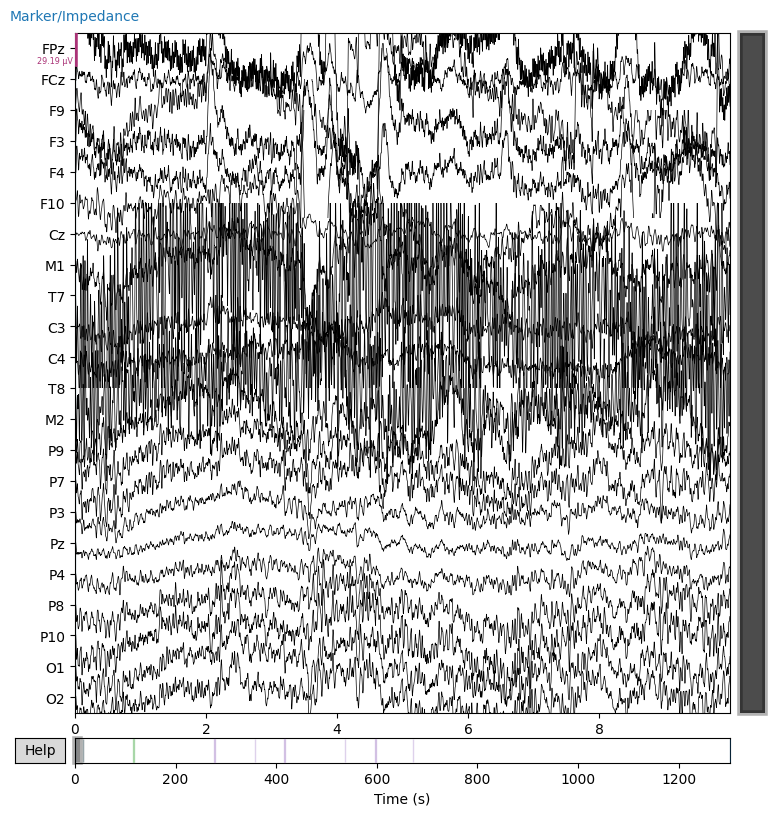

In [70]:
# plot raw data (Use show=False to prevent auto-display, then show explicitly)
raw_data.plot(duration=10.0, n_channels=22, scalings='auto', title='Classical Music - Raw Data', show=False)
plt.show()


## Interpretation of Raw Time-Series Data

- Frontal/Central channels show high-amplitude artifacts: Channels FPz, FCz, F9, F3, F4, F10, Cz, M1, T7, C3, C4, T8, M2 display very high amplitude, irregular, noisy activity with sharp deflections
- Posterior channels appear cleaner: Channels P9, P7, P3, Pz, P4, P8, P10, O1, O2 show lower amplitude, more organized waveforms typical of EEG signals
- Likely causes of artifacts: Muscle activity (jaw, neck, facial), electrode contact issues (high impedance (electrical resistance of the scalp)), or movement artifacts in frontal/central regions
- Recording quality: Posterior channels suggest the recording setup is generally functional; issues appear localized to specific electrodes

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


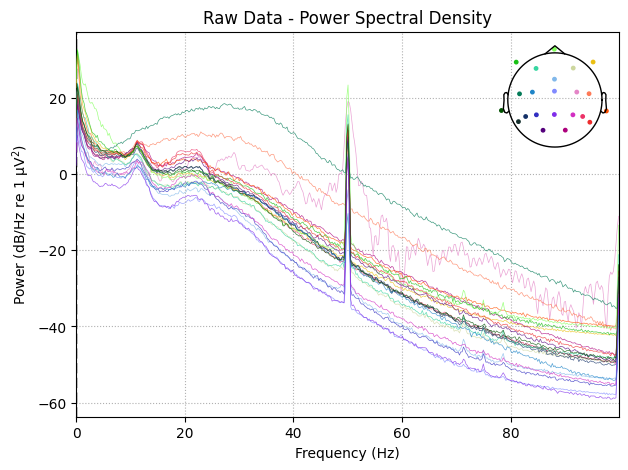

In [71]:
# Power spectral density of raw data
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

psd = raw_data.compute_psd(fmax=100)
psd.plot(axes=ax, show=False)
ax.set_title('Raw Data - Power Spectral Density')
plt.show()

## Interpretation of PSD Plot
- Prominent 50 Hz line noise: Sharp peak around 50 Hz across most channels, indicating power line interference that needs notch filtering
- High power at low frequencies: Elevated power in the delta/theta range (2-8 Hz), typical of EEG baseline activity
- Alpha/beta activity present: Broad peaks around 10-25 Hz, indicating alpha and beta band activity
- Power decreases with frequency: General decline from low to high frequencies, consistent with EEG
- Channel variability: Differences in power levels across channels, reflecting spatial differences in brain activity
- Pre-filtering state: This is raw data; the 50 Hz peak should be removed with notch filtering (50, 100 Hz)
- Frequency content: Most power concentrated below 40 Hz, supporting the 1-40 Hz bandpass filter range

## 4. Preprocessing Pipeline


### 4.1 Notch Filtering (Remove Line Noise)


In [72]:
# copy for preprocessing
raw_data_filtered = raw_data.copy()

# 50 and 100 Hz notch filters
raw_data_filtered.notch_filter([50, 100])


Filtering raw data in 1 contiguous segment


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

### 4.2 Bandpass Filtering (Keep 1-40 Hz)


In [73]:
# bandpass filter - 1-40 hz
raw_data_filtered.filter(l_freq=1, h_freq=40)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



<RawBrainVision | classical_A_M_2025-12-15_15-04-18.eeg, 22 x 651020 (1302.0 s), ~109.3 MiB, data loaded>

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


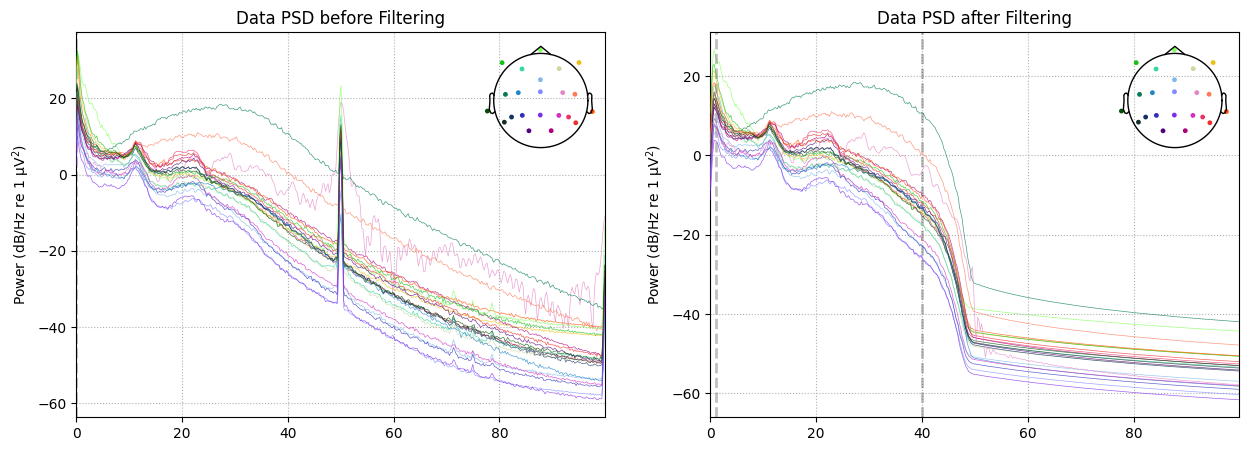

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Data PSD before filtering
psd_before = raw_data.compute_psd(fmax=100)
psd_before.plot(axes=axes[0], show=False)
axes[0].set_title('Data PSD before Filtering')

# Data PSD after filtering
psd_after = raw_data_filtered.compute_psd(fmax=100)
psd_after.plot(axes=axes[1], show=False)
axes[1].set_title('Data PSD after Filtering')

plt.show()


Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


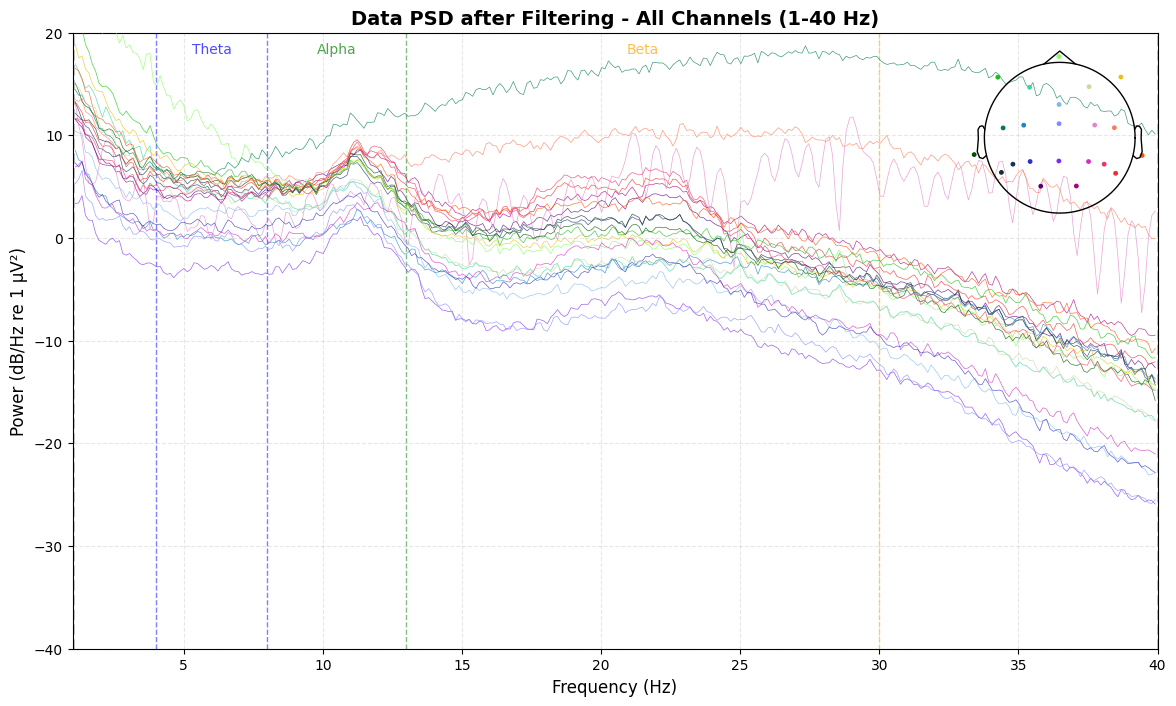

In [75]:
fig, ax = plt.subplots(figsize=(14, 8))

# Compute PSD with maximum frequency resolution
psd_after = raw_data_filtered.compute_psd(
    method='welch',
    fmin=1.0,
    fmax=40.0,
    n_fft=4096, 
    n_overlap=1024,  
    n_per_seg=None 
)

# Plot with all channels visible
psd_after.plot(axes=ax, show=False, picks='eeg', average=False) 
ax.set_title('Data PSD after Filtering - All Channels (1-40 Hz)', 
            fontsize=14, fontweight='bold')
ax.set_xlim(1, 40)
ax.set_ylim(-40, 20)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

# frequency band markers
ax.axvline(4, color='blue', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(8, color='blue', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(13, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(30, color='orange', linestyle='--', alpha=0.5, linewidth=1)

# text labels for frequency bands
ax.text(6, 18, 'Theta', ha='center', fontsize=10, color='blue', alpha=0.7)
ax.text(10.5, 18, 'Alpha', ha='center', fontsize=10, color='green', alpha=0.7)
ax.text(21.5, 18, 'Beta', ha='center', fontsize=10, color='orange', alpha=0.7)

ax.grid(True, alpha=0.3, linestyle='--')
plt.show()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


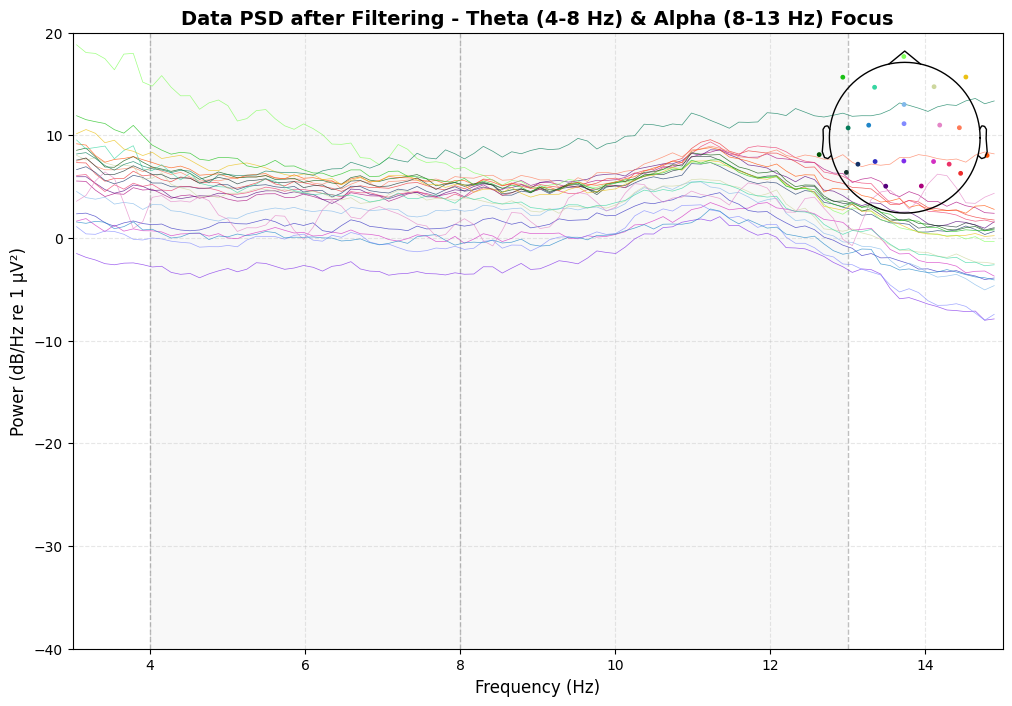

In [76]:
# pre-ICA PSD: Focus on theta and alpha bands only for iAF analysis
fig, ax = plt.subplots(figsize=(12, 8))

psd_after = raw_data_filtered.compute_psd(
    method='welch',
    fmin=3.0, 
    fmax=15.0, 
    n_fft=4096, 
    n_overlap=1024
)

psd_after.plot(axes=ax, show=False, picks='eeg', average=False)
ax.set_title('Data PSD after Filtering - Theta (4-8 Hz) & Alpha (8-13 Hz) Focus', 
            fontsize=14, fontweight='bold')
ax.set_xlim(3, 15)
ax.set_ylim(-40, 20)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

ax.axvline(4, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(13, color='gray', linestyle='--', alpha=0.5, linewidth=1)

ax.axvspan(4, 8, alpha=0.05, color='gray', linewidth=0)
ax.axvspan(8, 13, alpha=0.05, color='gray', linewidth=0)

ax.grid(True, alpha=0.3, linestyle='--')
plt.show()

### 4.3 ICA - Independent Component Analysis (Remove Artifacts)


Fitting ICA to data using 22 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.7s.


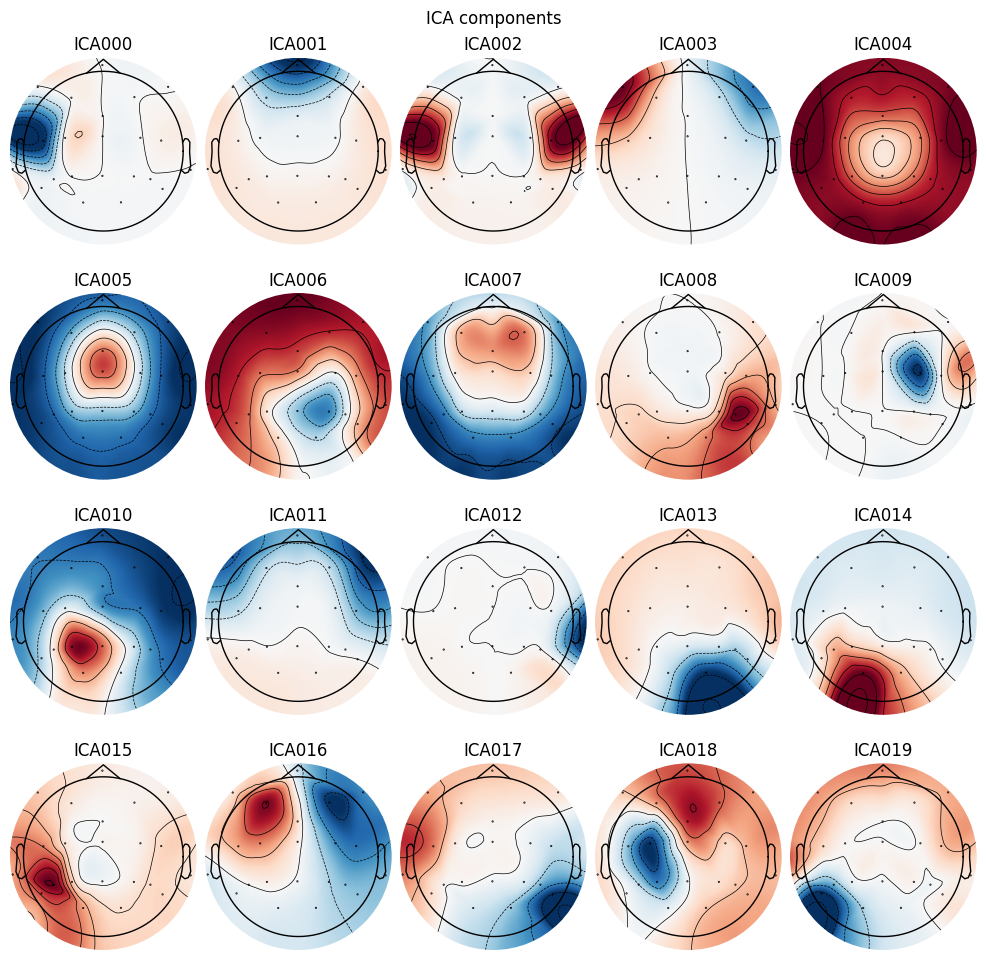

In [77]:
# fit ica on filtered data
ica_data = ICA(n_components=20, random_state=97, max_iter='auto')
ica_data.fit(raw_data_filtered)

# show ica components
fig = ica_data.plot_components()

# TODO: find artifacts to exclude in the next step

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated


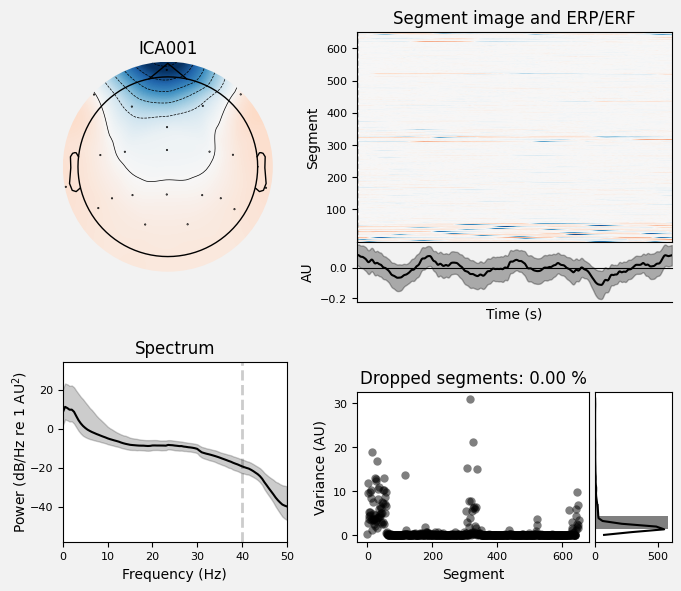

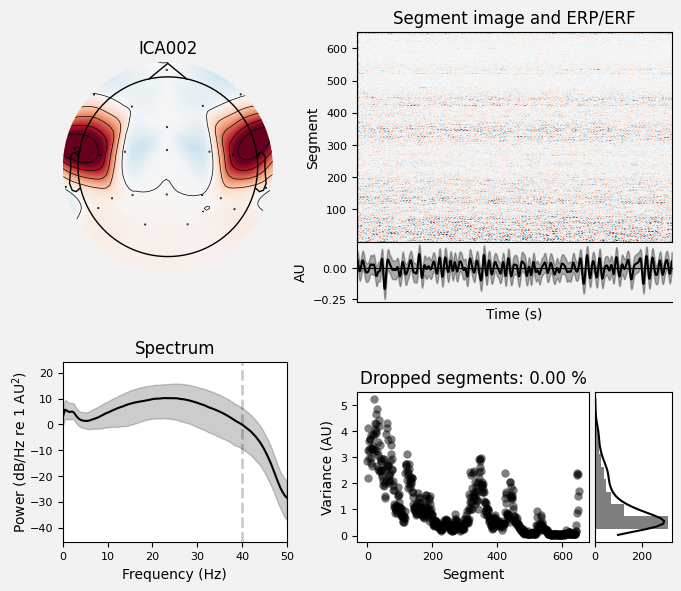

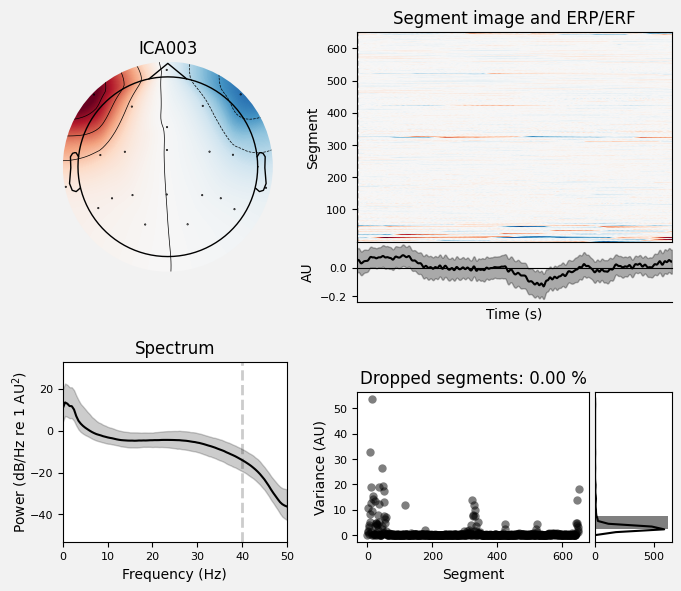

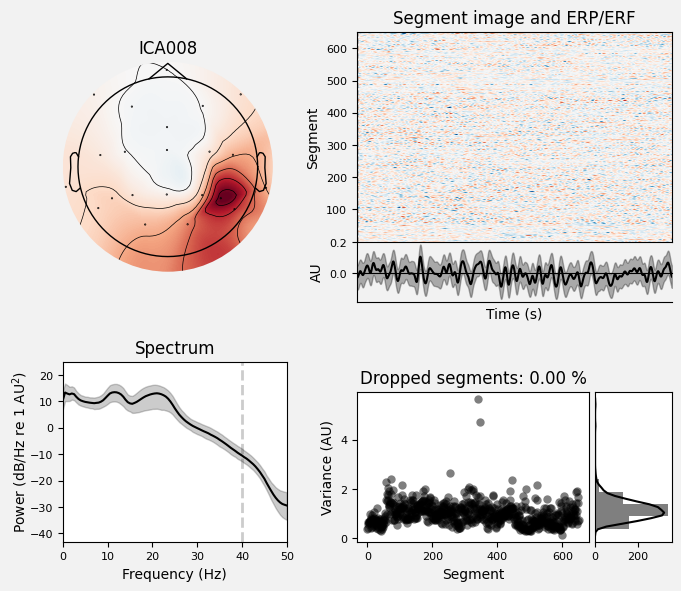

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [78]:
# ICA component properties - helps you find artifacts
# look for
# - activity frontal channels - eye blinks
# - activity temporal channels - muscle artifacts
# - unusual frequency content
ica_data.plot_properties(raw_data_filtered, picks=[1,2,3,8]) # change picks as needed


### 4.4 Apply ICA (Remove Artifacts)

**!!! IMPORTANT !!!** Before running this cell, you should:
1. Inspect the ICA components
2. Identify rtifacts
3. Set `ica.exclude`


In [79]:
ica_data.exclude = [1,2,3,8]  # indexes of excluded components

# apply ICA
raw_data_clean = ica_data.apply(raw_data_filtered.copy())


Applying ICA to Raw instance


    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 22 PCA components


## 5. Visualize Cleaned Data


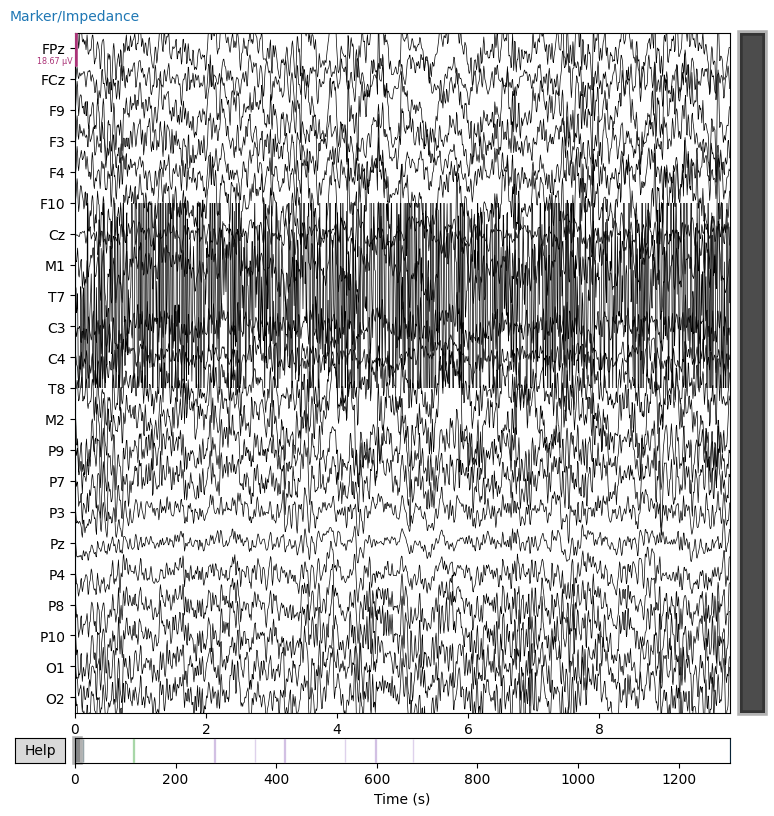

In [80]:
# plot clean data
raw_data_clean.plot(duration=10.0, n_channels=22, scalings='auto', 
                        title='Cleaned Data', show=False)
plt.show()

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


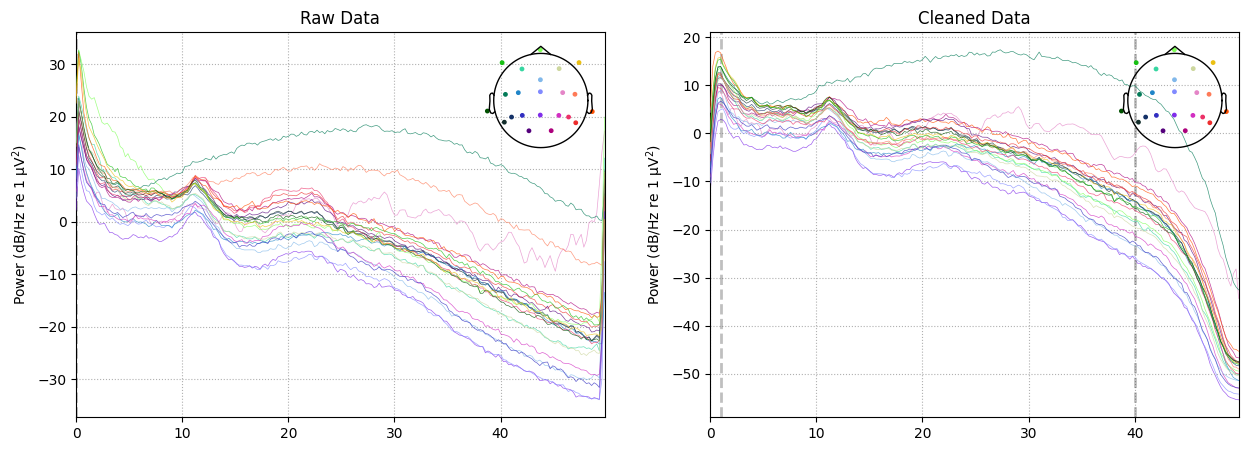

In [81]:
# compare psd before and after cleaning
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Raw data
psd_raw = raw_data.compute_psd(fmax=50)
psd_raw.plot(axes=axes[0], show=False)
axes[0].set_title('Raw Data')

# Cleaned data
psd_clean = raw_data_clean.compute_psd(fmax=50)
psd_clean.plot(axes=axes[1], show=False)
axes[1].set_title('Cleaned Data')

plt.show()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


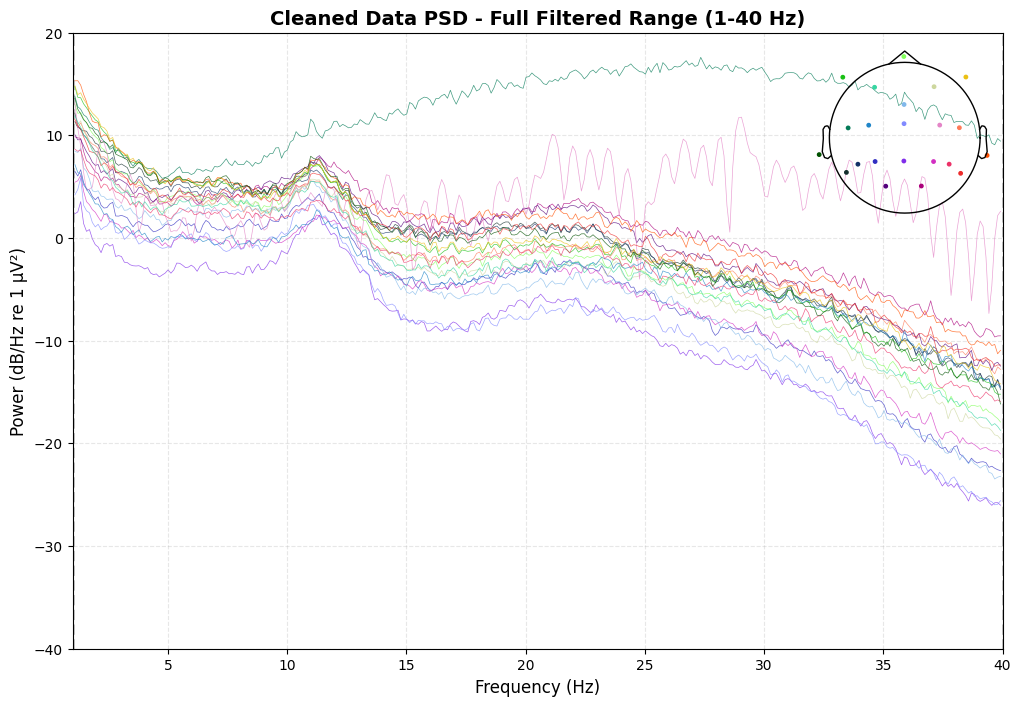

In [82]:
# post-ICA PSD: Full filtered range (1-40 Hz)
fig, ax = plt.subplots(figsize=(12, 8))

psd_clean = raw_data_clean.compute_psd(
    method='welch',
    fmin=1.0, 
    fmax=40.0, 
    n_fft=4096, 
    n_overlap=1024
)

psd_clean.plot(axes=ax, show=False, picks='eeg', average=False)
ax.set_title('Cleaned Data PSD - Full Filtered Range (1-40 Hz)', 
            fontsize=14, fontweight='bold')
ax.set_xlim(1, 40)
ax.set_ylim(-40, 20)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

ax.grid(True, alpha=0.3, linestyle='--')
plt.show()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


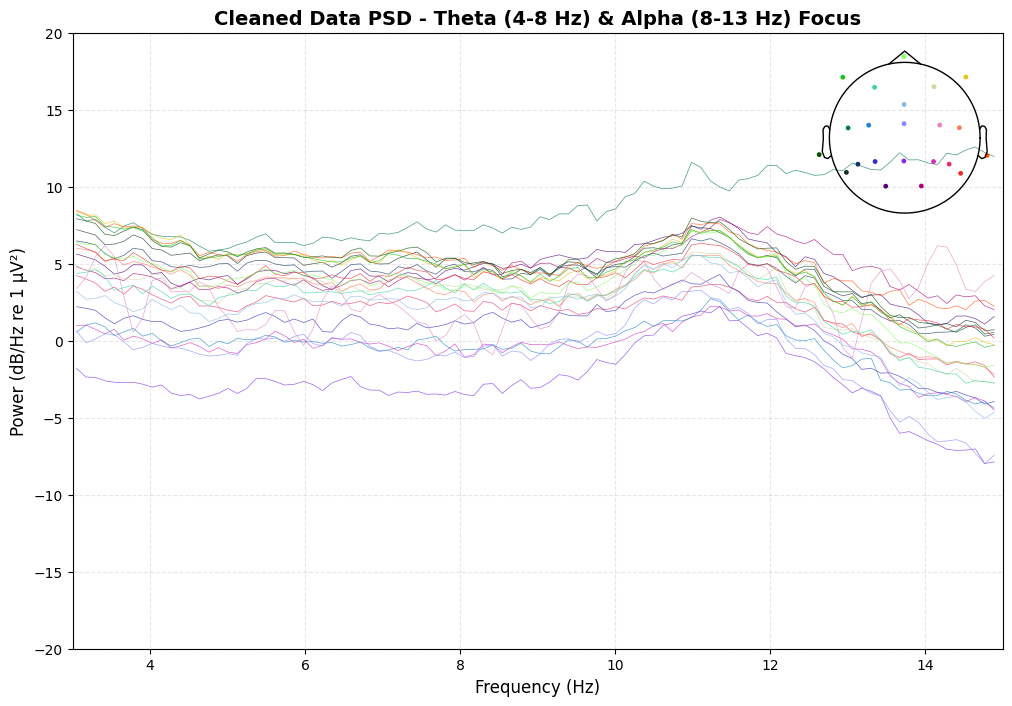

In [83]:
# post-ICA PSD: Focus on theta and alpha bands only for iAF analysis
fig, ax = plt.subplots(figsize=(12, 8))

psd_clean = raw_data_clean.compute_psd(
    method='welch',
    fmin=3.0, 
    fmax=15.0, 
    n_fft=4096, 
    n_overlap=1024
)

psd_clean.plot(axes=ax, show=False, picks='eeg', average=False)
ax.set_title('Cleaned Data PSD - Theta (4-8 Hz) & Alpha (8-13 Hz) Focus', 
            fontsize=14, fontweight='bold')
ax.set_xlim(3, 15)
ax.set_ylim(-20, 20)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power (dB/Hz re 1 µV²)', fontsize=12)

ax.grid(True, alpha=0.3, linestyle='--')
plt.show()

## 6. Epoching

Segment the continuous data into epochs based on experimental protocol phases.
s1000 marks the protocol start, and s1050 markers indicate the end of each phase.


In [84]:
# Extract protocol start and phase end markers
protocol_start = None
phase_ends = []

for i, (onset, duration, description) in enumerate(zip(
    raw_data_clean.annotations.onset,
    raw_data_clean.annotations.duration,
    raw_data_clean.annotations.description
)):
    desc_str = str(description)
    if 's1000' in desc_str:
        protocol_start = onset
        print(f"Protocol start (s1000): {onset:.1f}s")
    elif 's1050' in desc_str:
        phase_ends.append(onset)
        print(f"Phase end (s1050): {onset:.1f}s")

phase_ends.sort()
print(f"\nFound {len(phase_ends)} phase end markers")

if protocol_start is None:
    print("No s1000 marker found. Using first annotation as start.")
    protocol_start = raw_data_clean.annotations.onset[0]

Protocol start (s1000): 116.1s
Phase end (s1050): 276.0s
Phase end (s1050): 357.5s
Phase end (s1050): 416.4s
Phase end (s1050): 536.4s
Phase end (s1050): 596.2s
Phase end (s1050): 671.3s

Found 6 phase end markers


In [85]:
# Define phase boundaries based on actual markers
phase_boundaries = {}

if protocol_start is not None and len(phase_ends) > 0:
    phase_boundaries['phase_1'] = (protocol_start, phase_ends[0])
    
    for i in range(1, len(phase_ends)):
        phase_boundaries[f'phase_{i+1}'] = (phase_ends[i-1], phase_ends[i])
    
    recording_end = raw_data_clean.times[-1]
    phase_boundaries[f'phase_{len(phase_ends)+1}'] = (phase_ends[-1], recording_end)
    
    print(f"\nPhase boundaries:")
    for phase_name, (start, end) in phase_boundaries.items():
        duration = end - start
        print(f"  {phase_name}: {start:.1f}s - {end:.1f}s (duration: {duration:.1f}s = {duration/60:.1f} min)")
else:
    print("Cannot determine phase boundaries without markers")


Phase boundaries:
  phase_1: 116.1s - 276.0s (duration: 159.9s = 2.7 min)
  phase_2: 276.0s - 357.5s (duration: 81.5s = 1.4 min)
  phase_3: 357.5s - 416.4s (duration: 58.9s = 1.0 min)
  phase_4: 416.4s - 536.4s (duration: 120.0s = 2.0 min)
  phase_5: 536.4s - 596.2s (duration: 59.8s = 1.0 min)
  phase_6: 596.2s - 671.3s (duration: 75.0s = 1.3 min)
  phase_7: 671.3s - 1302.0s (duration: 630.8s = 10.5 min)


In [86]:
# Map phase boundaries to your experimental protocol
phase_labels = {
    'phase_1': 'baseline_EO',      # Eyes Open (2 min expected)
    'phase_2': 'baseline_EC',       # Eyes Closed (2 min expected)
    'phase_3': 'task_no_music',     # No music + finger tapping (2 min expected)
    'phase_4': 'break1',            # Break (1 min expected)
    'phase_5': 'task_music',        # Music + finger tapping (2 min expected)
    'phase_6': 'break2',            # Break (1 min expected)
    'phase_7': 'meditation',        # Meditation (10 min expected)
    # 'phase_8': 'post_EC'         # Post-meditation Eyes Closed (if exists, not available in all subjects)
}

# Create labeled phase boundaries
labeled_phases = {}
for phase_num, (start, end) in phase_boundaries.items():
    label = phase_labels.get(phase_num, phase_num)
    labeled_phases[label] = (start, end)
    
print(f"\nLabeled phases:")
for label, (start, end) in labeled_phases.items():
    duration = end - start
    print(f"  {label}: {start:.1f}s - {end:.1f}s ({duration/60:.1f} min)")


Labeled phases:
  baseline_EO: 116.1s - 276.0s (2.7 min)
  baseline_EC: 276.0s - 357.5s (1.4 min)
  task_no_music: 357.5s - 416.4s (1.0 min)
  break1: 416.4s - 536.4s (2.0 min)
  task_music: 536.4s - 596.2s (1.0 min)
  break2: 596.2s - 671.3s (1.3 min)
  meditation: 671.3s - 1302.0s (10.5 min)


In [87]:
# Create epochs for each experimental phase
epoch_duration = 2.0 
epoch_overlap = 0.0   

epochs_by_phase = {}

for phase_name, (abs_start, abs_end) in labeled_phases.items():
    # Check if phase is within recording
    if abs_end > raw_data_clean.times[-1]:
        print(f" {phase_name}: Phase extends beyond recording, adjusting end time")
        abs_end = raw_data_clean.times[-1]
    
    if abs_start < raw_data_clean.times[-1] and abs_end > abs_start:
        try:
            # Crop raw data to this phase
            raw_phase = raw_data_clean.copy().crop(tmin=abs_start, tmax=abs_end)
            
            # Create fixed-length epochs
            epochs_phase = mne.make_fixed_length_epochs(
                raw_phase,
                duration=epoch_duration,
                overlap=epoch_overlap,
                preload=True
            )
            
            epochs_by_phase[phase_name] = epochs_phase
            duration_min = (abs_end - abs_start) / 60
            print(f"✓ {phase_name}: Created {len(epochs_phase)} epochs ({abs_start:.1f}s - {abs_end:.1f}s, {duration_min:.1f} min)")
        except Exception as e:
            print(f" {phase_name}: Error creating epochs - {e}")
    else:
        print(f" {phase_name}: Invalid time range, skipping")

print(f"\n✓ Total phases with epochs: {len(epochs_by_phase)}")

Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 79 events and 1000 original time points ...
0 bad epochs dropped
✓ baseline_EO: Created 79 epochs (116.1s - 276.0s, 2.7 min)
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 1000 original time points ...
0 bad epochs dropped
✓ baseline_EC: Created 40 epochs (276.0s - 357.5s, 1.4 min)
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 29 events and 1000 original time points ...
0 bad epochs dropped
✓ task_no_music: Created 29 epochs (357.5s - 416.4s, 1.0 min)
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 1000 original time points ...
0 bad epochs droppe

In [88]:
# Verify phase durations match expected protocol
expected_durations = {
    'baseline_EO': 120,      
    'baseline_EC': 120,      
    'task_no_music': 120,   
    'break1': 60,          
    'task_music': 120,      
    'break2': 60,          
    'meditation': 600,
    'post_EC': 120          
}

print("\n=== Phase Duration Verification ===")
for phase_name, epochs_phase in epochs_by_phase.items():
    actual_duration = len(epochs_phase) * epoch_duration
    expected = expected_durations.get(phase_name, None)
    
    if expected:
        diff = actual_duration - expected
        print(f"{phase_name}: {actual_duration:.1f}s (expected: {expected}s, diff: {diff:+.1f}s)")
    else:
        print(f"{phase_name}: {actual_duration:.1f}s (no expected duration)")


=== Phase Duration Verification ===
baseline_EO: 158.0s (expected: 120s, diff: +38.0s)
baseline_EC: 80.0s (expected: 120s, diff: -40.0s)
task_no_music: 58.0s (expected: 120s, diff: -62.0s)
break1: 120.0s (expected: 60s, diff: +60.0s)
task_music: 58.0s (expected: 120s, diff: -62.0s)
break2: 74.0s (expected: 60s, diff: +14.0s)
meditation: 630.0s (expected: 600s, diff: +30.0s)


In [89]:
# Create combined epochs with metadata

all_epochs_list = []
all_metadata_list = []

for phase_name, epochs_phase in epochs_by_phase.items():
    n_epochs = len(epochs_phase)
    phase_metadata = pd.DataFrame({
        'phase': [phase_name] * n_epochs,
        'epoch_in_phase': range(n_epochs)
    })
    
    epochs_phase.metadata = phase_metadata
    all_epochs_list.append(epochs_phase)
    all_metadata_list.append(phase_metadata)

# Combine all epochs
if len(all_epochs_list) > 0:
    epochs_all_phases = mne.concatenate_epochs(all_epochs_list)
    epochs_all_phases.metadata = pd.concat(all_metadata_list, ignore_index=True)
    
    print(f"\n✓ Combined epochs: {len(epochs_all_phases)} total epochs")
    print(f"\nEpochs by phase:")
    print(epochs_all_phases.metadata['phase'].value_counts().to_dict())
else:
    print("No epochs created")

Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
Adding metadata with 2 columns
589 matching events found
No baseline correction applied
Replacing existing metadata with 2 columns

✓ Combined epochs: 589 total epochs

Epochs by phase:
{'meditation': 315, 'baseline_EO': 79, 'break1': 60, 'baseline_EC': 40, 'break2': 37, 'task_no_music': 29, 'task_music': 29}


/var/folders/z9/21wwc2sx0y96crz___73ywkw0000gn/T/ipykernel_74414/2818534857.py:19: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_all_phases = mne.concatenate_epochs(all_epochs_list)


In [90]:
# Summary table of epochs by phase
summary_data = []
for phase_name, epochs_phase in epochs_by_phase.items():
    n_epochs = len(epochs_phase)
    phase_start = labeled_phases[phase_name][0]
    phase_end = labeled_phases[phase_name][1]
    phase_duration = phase_end - phase_start
    
    summary_data.append({
        'Phase': phase_name,
        'Start (s)': round(phase_start, 1),
        'End (s)': round(phase_end, 1),
        'Duration (s)': round(phase_duration, 1),
        'Duration (min)': round(phase_duration/60, 2),
        'N Epochs': n_epochs,
        'Epoch Duration (s)': round(epoch_duration, 1),
        'Total Epoch Time (s)': round(n_epochs * epoch_duration, 1)
    })

summary_df = pd.DataFrame(summary_data)
summary_df

Phase  Start (s)  End (s)  Duration (s)  Duration (min)  N Epochs  \
0    baseline_EO      116.1    276.0         159.9            2.67        79   
1    baseline_EC      276.0    357.5          81.5            1.36        40   
2  task_no_music      357.5    416.4          58.9            0.98        29   
3         break1      416.4    536.4         120.0            2.00        60   
4     task_music      536.4    596.2          59.8            1.00        29   
5         break2      596.2    671.3          75.0            1.25        37   
6     meditation      671.3   1302.0         630.8           10.51       315   

   Epoch Duration (s)  Total Epoch Time (s)  
0                 2.0                 158.0  
1                 2.0                  80.0  
2                 2.0                  58.0  
3                 2.0                 120.0  
4                 2.0                  58.0  
5                 2.0                  74.0  
6                 2.0                 630.0

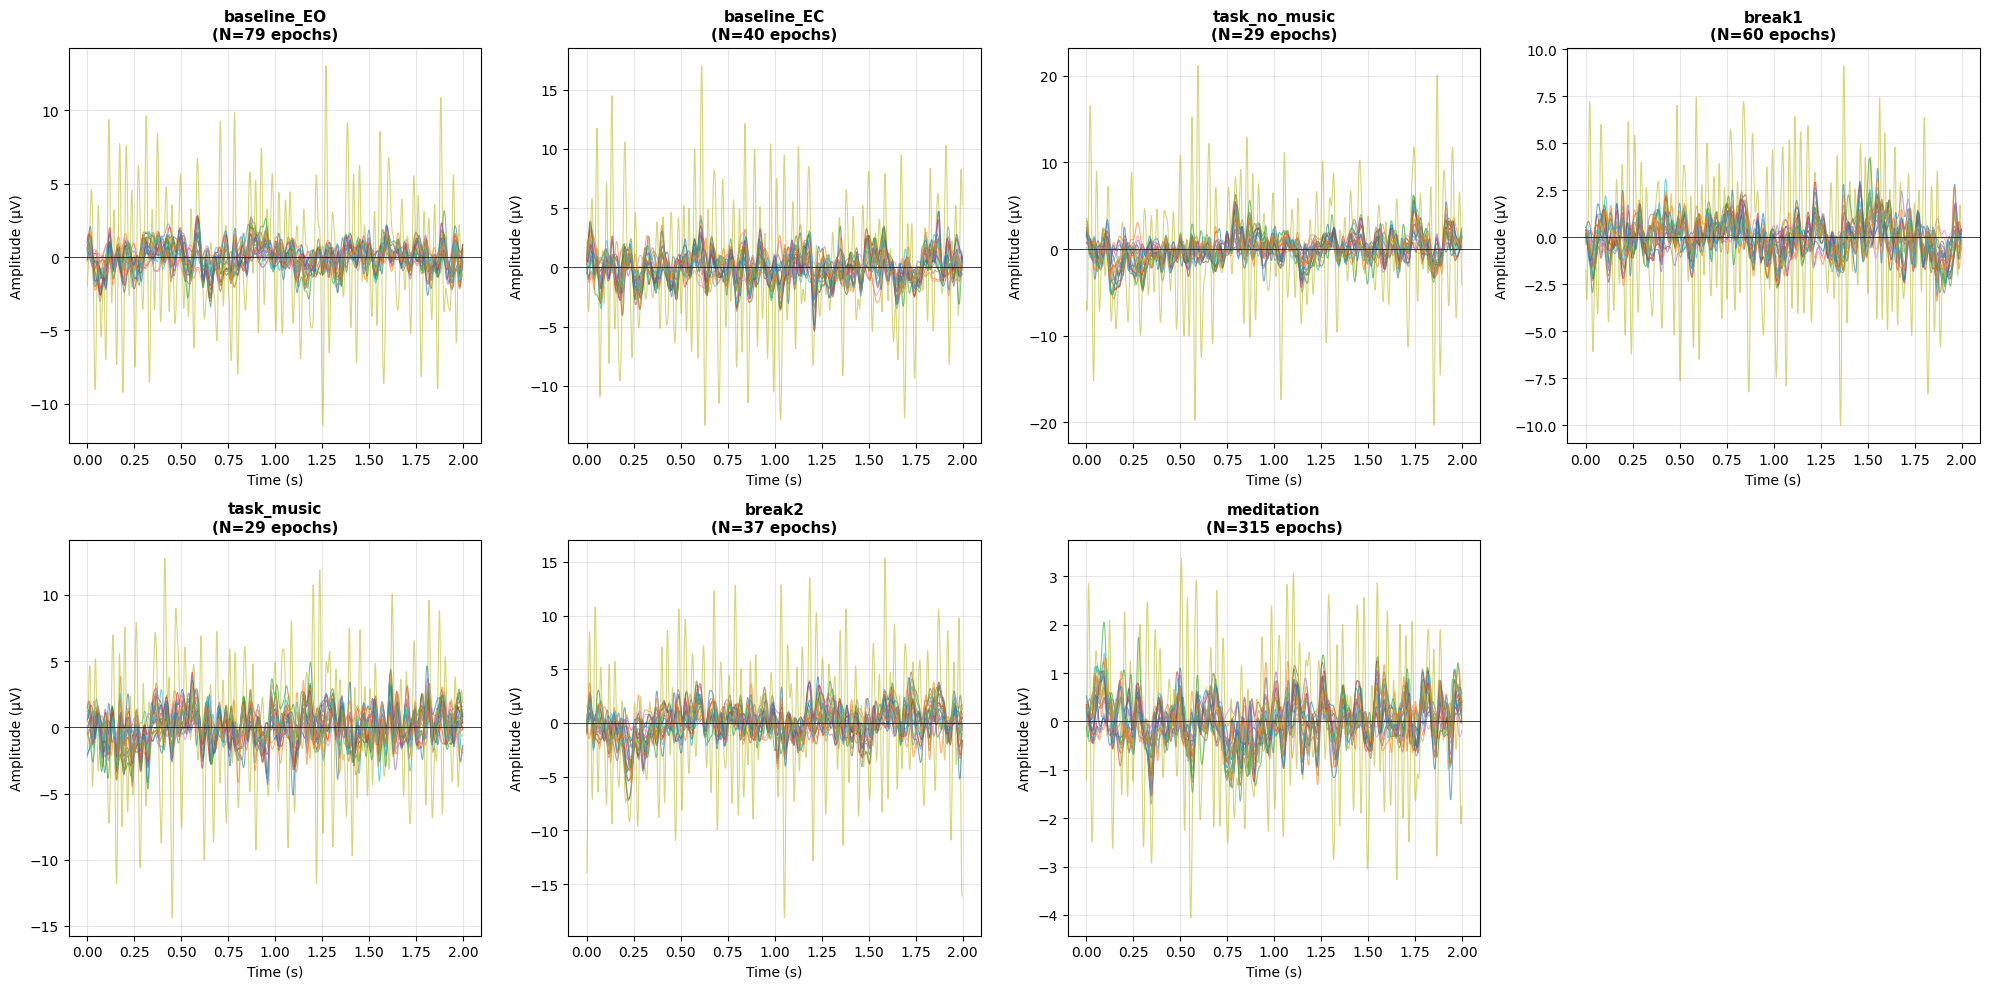

In [91]:
# signal amplitude visualization
phases_with_data = [(name, epochs) for name, epochs in epochs_by_phase.items() if len(epochs) > 0]

n_phases = len(phases_with_data)
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for idx, (phase_name, epochs_phase) in enumerate(phases_with_data):
    evoked = epochs_phase.average()
    data = evoked.get_data()  # Shape: (n_channels, n_times)
    times = evoked.times
    
    for ch_idx in range(data.shape[0]):
        axes[idx].plot(times, data[ch_idx, :] * 1e6, alpha=0.6, linewidth=0.8)
    
    axes[idx].set_xlabel('Time (s)', fontsize=10)
    axes[idx].set_ylabel('Amplitude (µV)', fontsize=10)
    axes[idx].set_title(f'{phase_name}\n(N={len(epochs_phase)} epochs)', 
                       fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(0, color='black', linestyle='-', linewidth=0.5)

for idx in range(n_phases, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Observations 
- Meditation phase stands out:
    - Much lower amplitudes (-4 to 3 µV) vs others (-10 to 20 µV)
    - More stable signal
    - 315 epochs (longest phase)
- Consistent with a relaxed/meditative state
    - Task phases show higher activity:
    - task_no_music: highest amplitudes (-20 to 20 µV)
    - task_music: moderate amplitudes (-15 to 15 µV)
    - Expected during active tasks
- Baseline phases:
    - baseline_EO and baseline_EC: moderate amplitudes
    - baseline_EC slightly higher than baseline_EO (typical)
- Break phases:
    - Lower amplitudes, more stable
    - Consistent with rest periods

In [92]:
# Summary table of epochs by phase
comprehensive_data = []

for phase_name, epochs_phase in epochs_by_phase.items():
    if len(epochs_phase) > 0:
        data = epochs_phase.get_data()
        phase_start, phase_end = labeled_phases[phase_name]
        
        # Overall statistics
        max_amp = np.abs(data).max() * 1e6
        mean_amp = np.abs(data).mean() * 1e6
        std_amp = data.std() * 1e6
        
        # Per-channel average
        channel_means = np.abs(data).mean(axis=(0, 2)) * 1e6
        max_channel_amp = channel_means.max()
        min_channel_amp = channel_means.min()
        mean_channel_amp = channel_means.mean()
        
        comprehensive_data.append({
            'Phase': phase_name,
            'N_Epochs': len(epochs_phase),
            'Start_s': phase_start,
            'End_s': phase_end,
            'Duration_s': phase_end - phase_start,
            'Duration_min': (phase_end - phase_start) / 60,
            'Max_Amp_µV': max_amp,
            'Mean_Amp_µV': mean_amp,
            'Std_Amp_µV': std_amp,
            'Max_Channel_Mean_µV': max_channel_amp,
            'Min_Channel_Mean_µV': min_channel_amp,
            'Mean_Channel_Mean_µV': mean_channel_amp
        })

comprehensive_df = pd.DataFrame(comprehensive_data)
comprehensive_df

Phase  N_Epochs  Start_s     End_s  Duration_s  Duration_min  \
0    baseline_EO        79  116.072   275.982     159.910      2.665167   
1    baseline_EC        40  275.982   357.486      81.504      1.358400   
2  task_no_music        29  357.486   416.380      58.894      0.981567   
3         break1        60  416.380   536.404     120.024      2.000400   
4     task_music        29  536.404   596.228      59.824      0.997067   
5         break2        37  596.228   671.252      75.024      1.250400   
6     meditation       315  671.252  1302.038     630.786     10.513100   

   Max_Amp_µV  Mean_Amp_µV  Std_Amp_µV  Max_Channel_Mean_µV  \
0  171.554685     7.012961   11.185333            30.905217   
1  134.962967     6.836040   10.372200            26.564239   
2  117.898173     6.622639    9.799775            23.989713   
3  100.690378     6.231326    8.947915            20.025881   
4  105.523944     6.348406    9.253719            21.463429   
5  129.833449     7.181120   10.875286            26.553053   
6  167.378128     6.258153    9.147033            18.692134   

   Min_Channel_Mean_µV  Mean_Channel_Mean_µV  
0             2.994972              7.012961  
1             3.072767              6.836040  
2             2.895948              6.622639  
3             2.722642              6.231326  
4             2.686485              6.348406  
5             2.993616              7.181120  
6             2.648998              6.258153

## 7. Power Analysis (Alpha & Theta)

### Extract power in alpha (8-13 Hz) and theta (4-8 Hz) frequency bands and compare between experimental phases (baseline, meditation, post-meditation)

In [93]:
# Compute PSD for each experimental phase
psd_by_phase = {}

for phase_name, epochs_phase in epochs_by_phase.items():
    print(f"Computing PSD for {phase_name}...")
    psd_by_phase[phase_name] = epochs_phase.compute_psd(
        method='welch',
        fmin=1.0,
        fmax=40.0
    )
    print(f"  ✓ {phase_name}: {len(epochs_phase)} epochs, {len(psd_by_phase[phase_name].ch_names)} channels")

Computing PSD for baseline_EO...
Effective window size : 2.000 (s)
  ✓ baseline_EO: 79 epochs, 22 channels
Computing PSD for baseline_EC...
Effective window size : 2.000 (s)
  ✓ baseline_EC: 40 epochs, 22 channels
Computing PSD for task_no_music...
Effective window size : 2.000 (s)
  ✓ task_no_music: 29 epochs, 22 channels
Computing PSD for break1...
Effective window size : 2.000 (s)
  ✓ break1: 60 epochs, 22 channels
Computing PSD for task_music...
Effective window size : 2.000 (s)
  ✓ task_music: 29 epochs, 22 channels
Computing PSD for break2...
Effective window size : 2.000 (s)
  ✓ break2: 37 epochs, 22 channels
Computing PSD for meditation...
Effective window size : 2.000 (s)
  ✓ meditation: 315 epochs, 22 channels


In [94]:
# Extract theta and alpha power for each phase
freq_bands = {
    'theta': (4, 8),   # Theta: 4-8 Hz
    'alpha': (8, 13),  # Alpha: 8-13 Hz
}

phase_power_results = {}

for phase_name, psd_phase in psd_by_phase.items():
    # Extract theta power (average across frequencies in band, across epochs)
    theta_power = psd_phase.get_data(fmin=4, fmax=8).mean(axis=-1).mean(axis=0)  # Shape: (n_channels,)
    
    # Extract alpha power
    alpha_power = psd_phase.get_data(fmin=8, fmax=13).mean(axis=-1).mean(axis=0)  # Shape: (n_channels,)
    
    # Convert from V²/Hz to µV²/Hz (1 µV = 1e-6 V, so 1 µV² = 1e-12 V²)
    theta_power_µV = theta_power * 1e12
    alpha_power_µV = alpha_power * 1e12
    
    # Calculate iAF ratio (alpha/theta)
    iaf_ratio = alpha_power_µV / theta_power_µV
    
    phase_power_results[phase_name] = {
        'theta': theta_power_µV,
        'alpha': alpha_power_µV,
        'iaf_ratio': iaf_ratio,
        'channels': psd_phase.ch_names
    }
    
    print(f"\n{phase_name}:")
    print(f"  Mean Theta Power: {theta_power_µV.mean():.4f} µV²/Hz")
    print(f"  Mean Alpha Power: {alpha_power_µV.mean():.4f} µV²/Hz")
    print(f"  Mean iAF Ratio: {iaf_ratio.mean():.4f}")


baseline_EO:
  Mean Theta Power: 2.1625 µV²/Hz
  Mean Alpha Power: 3.0126 µV²/Hz
  Mean iAF Ratio: 1.3941

baseline_EC:
  Mean Theta Power: 2.4079 µV²/Hz
  Mean Alpha Power: 3.3592 µV²/Hz
  Mean iAF Ratio: 1.3992

task_no_music:
  Mean Theta Power: 2.4057 µV²/Hz
  Mean Alpha Power: 2.6618 µV²/Hz
  Mean iAF Ratio: 1.1493

break1:
  Mean Theta Power: 2.2746 µV²/Hz
  Mean Alpha Power: 2.3329 µV²/Hz
  Mean iAF Ratio: 1.0357

task_music:
  Mean Theta Power: 2.1706 µV²/Hz
  Mean Alpha Power: 2.3868 µV²/Hz
  Mean iAF Ratio: 1.1861

break2:
  Mean Theta Power: 2.4281 µV²/Hz
  Mean Alpha Power: 2.5195 µV²/Hz
  Mean iAF Ratio: 1.0908

meditation:
  Mean Theta Power: 2.3509 µV²/Hz
  Mean Alpha Power: 2.4728 µV²/Hz
  Mean iAF Ratio: 1.0721


In [95]:
# Df for analysis
import pandas as pd

results = []
for phase_name, power_data in phase_power_results.items():
    for ch_idx, ch_name in enumerate(power_data['channels']):
        results.append({
            'Phase': phase_name,
            'Channel': ch_name,
            'Theta_Power_µV²': power_data['theta'][ch_idx],
            'Alpha_Power_µV²': power_data['alpha'][ch_idx],
            'iAF_Ratio': power_data['iaf_ratio'][ch_idx]
        })

power_analysis_df = pd.DataFrame(results)
power_analysis_df  

Phase Channel  Theta_Power_µV²  Alpha_Power_µV²  iAF_Ratio
0    baseline_EO     FPz         2.336674         2.762019   1.182030
1    baseline_EO     FCz         1.597049         2.206934   1.381882
2    baseline_EO      F9         3.192296         3.034105   0.950446
3    baseline_EO      F3         1.801203         2.101536   1.166740
4    baseline_EO      F4         1.944285         2.363124   1.215421
..           ...     ...              ...              ...        ...
149   meditation      P4         0.948710         0.976567   1.029363
150   meditation      P8         1.814787         1.609199   0.886715
151   meditation     P10         2.777995         2.663239   0.958691
152   meditation      O1         2.517246         3.180878   1.263634
153   meditation      O2         2.426679         3.771077   1.554007

[154 rows x 5 columns]

In [96]:
# Summary statistics by phase
summary = power_analysis_df.groupby('Phase').agg({
    'Theta_Power_µV²': ['mean', 'std'],
    'Alpha_Power_µV²': ['mean', 'std'],
    'iAF_Ratio': ['mean', 'std']
})
print("\n=== Summary Statistics by Phase ===")
print(summary)


=== Summary Statistics by Phase ===
              Theta_Power_µV²           Alpha_Power_µV²           iAF_Ratio  \
                         mean       std            mean       std      mean   
Phase                                                                         
baseline_EC          2.407885  1.193706        3.359193  2.471735  1.399182   
baseline_EO          2.162531  1.075044        3.012633  2.401484  1.394070   
break1               2.274599  1.003128        2.332851  1.257093  1.035724   
break2               2.428068  1.315327        2.519504  1.711934  1.090834   
meditation           2.350862  1.107093        2.472820  1.393392  1.072114   
task_music           2.170559  1.095964        2.386807  1.430869  1.186129   
task_no_music        2.405749  1.248298        2.661839  1.564726  1.149265   

                         
                    std  
Phase                    
baseline_EC    0.434671  
baseline_EO    0.405268  
break1         0.231277  
break2         0